#### Intall Transformers

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-prepared/data_sample_prepared.csv


In [1]:
!pip install transformers

Mounted Google Drive to access Data prepared from the Jigsaw Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#### Read Dataset

In [4]:
import pandas as pd

df = pd.read_csv('../input/data-prepared/data_sample_prepared.csv')

In [5]:
df.shape

(23507, 3)

In [6]:
df.head(10)

,Gender,Comment,Gender_Label
0,f,i d like to think that the difference will be ...,0
1,f,really j bob so racism doesn t exist i m not b...,0
2,f,several of the american founders disagreed wit...,0
3,f,i think it is misleading to be overconcerned w...,0
4,f,i disagree with your comment about the police ...,0
5,f,yet the christian bible and christian theology...,0
6,f,well put,0
7,m,unfortunately i do not know much about that ot...,1
8,f,pure hogwash claiming a truckers strike in pue...,0
9,f,yup it seems to be happening more frequently l...,0


In [7]:
label_counts = pd.DataFrame(df['Gender'].value_counts())
label_counts

,Gender
f,21030
m,2477


Here we create an array with the label names in the order they were numerically encoded. We will use them later when plotting model performance data.



In [19]:
label_values = list(label_counts.index)
order = list(pd.DataFrame(df['Gender_Label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]

label_values

['f', 'm']

We have created 2 arrays: one with the textual data (Comments), which is our feature data, and one with the numerically encoded labels(Gender), representing our target data.



In [8]:
texts = df['Comment'].values
labels = df['Gender_Label'].values

In [9]:
text_lengths = [len(texts[i].split()) for i in range(len(texts))]
print(min(text_lengths))
print(max(text_lengths))

1
207


In [10]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= 200])

8

#### Initiate BERT Tokenizer

In [11]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Original Text:  i d like to think that the difference will be that the majority of rational thinking alaskans want a responsible state fiscal plan instead of kicking a year to year budget down the road a fiscal plan is the key words here robb 

Tokenized Text:  ['i', 'd', 'like', 'to', 'think', 'that', 'the', 'difference', 'will', 'be', 'that', 'the', 'majority', 'of', 'rational', 'thinking', 'alaska', '##ns', 'want', 'a', 'responsible', 'state', 'fiscal', 'plan', 'instead', 'of', 'kicking', 'a', 'year', 'to', 'year', 'budget', 'down', 'the', 'road', 'a', 'fiscal', 'plan', 'is', 'the', 'key', 'words', 'here', 'robb'] 

Token IDs:  [1045, 1040, 2066, 2000, 2228, 2008, 1996, 4489, 2097, 2022, 2008, 1996, 3484, 1997, 11581, 3241, 7397, 3619, 2215, 1037, 3625, 2110, 10807, 2933, 2612, 1997, 10209, 1037, 2095, 2000, 2095, 5166, 2091, 1996, 2346, 1037, 10807, 2933, 2003, 1996, 3145, 2616, 2182, 26211]


We have tokenize and encoded the entire dataset. In this process, we perform the following:

 * tokenize the text 
 * encode it to the corresponding numeric values for each token. 
 * truncate it to the maximum sequence length of 100.
 * pad the tokens positions greater than 100.
 * include the special token IDs to mark the beginning and end of each sequence.

In [12]:
text_ids = [tokenizer.encode(text, max_length=100, pad_to_max_length=True) for text in texts]

text_ids[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[101,
 1045,
 1040,
 2066,
 2000,
 2228,
 2008,
 1996,
 4489,
 2097,
 2022,
 2008,
 1996,
 3484,
 1997,
 11581,
 3241,
 7397,
 3619,
 2215,
 1037,
 3625,
 2110,
 10807,
 2933,
 2612,
 1997,
 10209,
 1037,
 2095,
 2000,
 2095,
 5166,
 2091,
 1996,
 2346,
 1037,
 10807,
 2933,
 2003,
 1996,
 3145,
 2616,
 2182,
 26211,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [13]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))

100
100


In [14]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)
    
att_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### Splitting data into Train, Test and Validation sets 

In [15]:
from sklearn.model_selection import train_test_split

train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=111, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=111, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=111, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=111, test_size=0.5)

Declare PyTorch tensors

In [16]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([18805, 100])
torch.Size([2351, 100])
torch.Size([2351, 100])
torch.Size([18805])
torch.Size([2351])
torch.Size([2351])
torch.Size([18805, 100])
torch.Size([2351, 100])
torch.Size([2351, 100])


In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

#### Initiate Model

In [18]:
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig

num_labels = len(set(labels))

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
                                                            output_attentions=False, output_hidden_states=False)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Check for the device, Since BERT is a Large Datset, it's will be better to run the model with gpu

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


Model Architecture and Parameters

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model), '\n', model)

Number of trainable parameters: 66955010 
 DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (drop

Initiate Pytorch Optimizer

In [22]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [23]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 4
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

To keep track of time on the model running process, initiated a function to measure the time taken

In [24]:

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
import numpy as np
import random

seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()
    
    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()
        
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)
        
        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        
        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.data / num_mb_train
    
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
    
    with torch.no_grad():
        model.eval()
        
        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)
        
            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
            #loss = model_loss(outputs[1], mb_y)
            
            val_loss += loss.data / num_mb_val
            
        print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
        val_losses.append(val_loss.cpu())
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Train loss after itaration 1: 0.074647
Validation loss after itaration 1: 0.092821
Time: 1m 40s

Train loss after itaration 2: 0.063061
Validation loss after itaration 2: 0.089406
Time: 1m 40s

Train loss after itaration 3: 0.057120
Validation loss after itaration 3: 0.088557
Time: 1m 39s

Train loss after itaration 4: 0.057068
Validation loss after itaration 4: 0.088557
Time: 1m 40s


#### Save the Model

In [28]:
import pickle
import os

out_dir = './'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

with open(out_dir + '/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)
    
with open(out_dir + '/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

Load the Saved Model

In [29]:
out_dir = './'

model = DistilBertForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with open(out_dir + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(out_dir + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

Plot Training Loss

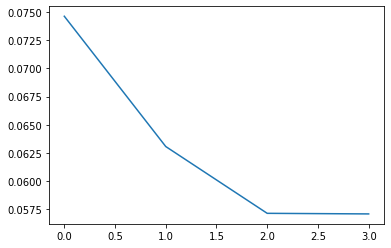

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)

Plot Validation Loss

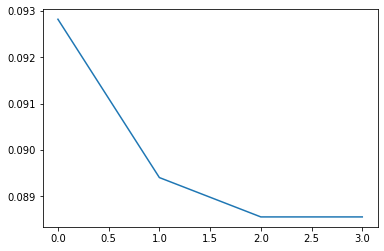

In [31]:
plt.figure()
plt.plot(val_losses)

Predict Score on the Test Data

In [32]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)

In [33]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

Compute Accuracy

In [34]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9770310506167589


#### Classification Report

In [35]:
from sklearn.metrics import classification_report

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

              precision    recall  f1-score   support

           f       0.98      0.99      0.99      2110
           m       0.92      0.85      0.88       241

    accuracy                           0.98      2351
   macro avg       0.95      0.92      0.94      2351
weighted avg       0.98      0.98      0.98      2351



#### Plot Confusion Matrix

In [36]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2091   19]
 [  35  206]]
Normalized confusion matrix
[[0.99 0.01]
 [0.15 0.85]]


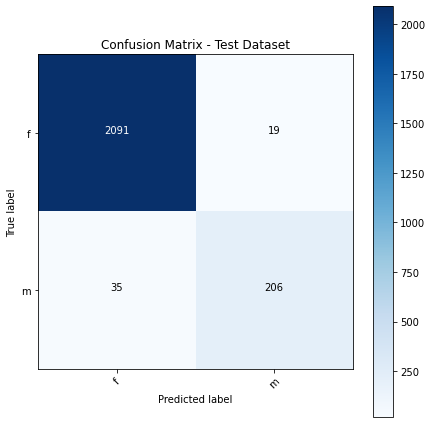

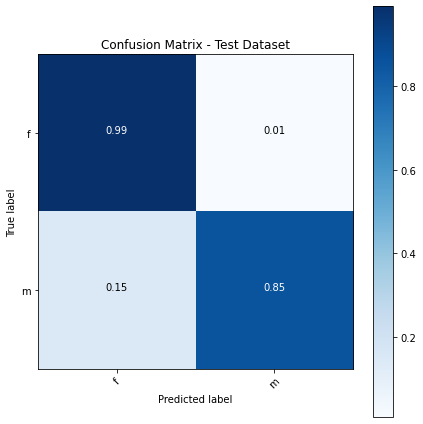

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)
